# TD3 on Car Racing V2

In [1]:
# # General
import platform
assert platform.python_version() == "3.10.14"
# !pip install 'gymnasium[box2d]'
# !pip install 'syne-tune[basic]'
# !pip install 'stable-baselines3[extra]'

## Hyperparameter Tuning

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from syne_tune import Tuner
from syne_tune.backend import PythonBackend
from syne_tune.experiments import load_experiment
from syne_tune.config_space import loguniform, uniform
from syne_tune.optimizer.baselines import ASHA
from syne_tune.stopping_criterion import StoppingCriterion

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/adavidho/.config/sagemaker/config.yaml


In [3]:
# Define the hyperparameter search space
config_space = {
    "learning_rate": loguniform(1e-8, 0.1),
    "tau":  loguniform(1e-8, 1),
    "gamma": uniform(0.9, 0.999),    
    "steps": 100000 
}

In [4]:
# Define the tuning function
def train_hpo_model(learning_rate: float, tau: float, gamma: float, steps: int):
    # Worker imports
    import numpy as np
    from stable_baselines3.common.env_util import make_vec_env
    from stable_baselines3.common.callbacks import BaseCallback
    from stable_baselines3.common.noise import NormalActionNoise
    from stable_baselines3 import TD3
    
    from syne_tune import Reporter

    # Create the vectorized environment
    env_id = "CarRacing-v2"
    vec_env = make_vec_env(env_id, n_envs=4)
    
    # Initialize the PPO agent with the given hyperparameters
    n_actions = vec_env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))  
    model = TD3("CnnPolicy", vec_env,  
                action_noise=action_noise,
                learning_rate=learning_rate,
                tau=tau,
                gamma=gamma,
                batch_size=32,
                verbose=1)

    report = Reporter()
    class WorkerCallback(BaseCallback):
        def _on_step(self) -> bool:
            # Log the mean reward
            mean_reward = sum(self.locals["rewards"]) / len(self.locals["rewards"])
            step = self.locals["num_collected_steps"]
            report(step=step, mean_reward=mean_reward)
            return True 
    
    # Train the agent
    worker_callback = WorkerCallback()
    model.learn(total_timesteps=steps, callback=worker_callback)

In [5]:
metric = "mean_reward"
scheduler = ASHA(
    config_space,
    metric=metric,
    max_resource_attr="steps",
    resource_attr="step",
    mode="max",
)
trial_backend = PythonBackend(
    tune_function=train_hpo_model, config_space=config_space
)
stop_criterion = StoppingCriterion(
    max_wallclock_time=61200, 
)
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=8,
    save_tuner=False,
    wait_trial_completion_when_stopping=True,
)

In [6]:
# Start hyperparameter tuning
tuner.run()

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate          tau        gamma      steps  step  mean_reward worker-time
        0    Stopped   129    7.88267e-06  5.47516e-03  5.40364e-01    4059.34     1      1.45570    8118.69
        1  Completed  1212    9.51271e-06  1.66619e-03  9.14142e-01   11781.48     1      7.42613    23562.96
        2  Completed   579    2.81416e-06  7.36647e-03  9.09822e-01    9259.44     1      7.68924    18518.88
        3  Completed  1141    8.75483e-06  9.09624e-03  9.46999e-01    5047.35     1      4.12335    10094.70
        4  Completed  1441    3.02342e-06  2.27268e-03  3.71751e-01    7804.32     1      5.41025    15608.63
        5  Completed  2349    2.80457e-06  4.34460e-03  3.29197e-01    2359.99     1      6.60238    4719.98
        6    Stopped   544    7.00647e-06  3.60703e-03  1.39702e-01    2005.98     1      2.47842    4011.96
        7    Stopped  1487    9.00671e-06  2.90336e-03  2.

In [7]:
# Get results
tuner_path = tuner.tuner_path
tuning_experiment = load_experiment(tuner_path)
best_run = tuning_experiment.best_config()
tuning_experiment.results.to_csv("artifacts/tune_logs/tuning_results.csv")

In [8]:
print("Number of tuning jobs:", len(tuning_experiment.results))
print("Best mean reward:", round(best_run["mean_reward"], 4))
print("Best tuning configuration:")
for i in ["config_learning_rate", "config_tau", "config_gamma"]:
    print(f" - {i}: {best_run[i]:.4e}")

Number of tuning jobs: 65004
Best mean reward: 75.6865
Best tuning configuration:
 - config_learning_rate: 5.6672e-05
 - config_tau: 7.2524e-06
 - config_gamma: 9.7588e-01


## Training

In [9]:
import numpy as np
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3 import TD3

In [10]:
# Create the vectorized environment
env_id = "CarRacing-v2"
log_dir = "./artifacts/train_logs/"
env = gym.make(env_id, domain_randomize=False, render_mode="rgb_array") 
env = Monitor(env, log_dir, allow_early_resets=True)

In [11]:
# Initialize optimal hyperparameters
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))  
learning_rate = best_run.config_learning_rate
tau = best_run.config_tau
gamma = best_run.config_gamma
# Create the TD3 Agent
model = TD3(
    "CnnPolicy", 
    env,  
    action_noise=action_noise,
    learning_rate=0.001,
    tau=0.5,
    gamma=gamma,
    batch_size=32,
    verbose=1,
    device="cuda"
)

Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [12]:
# Use DummyVecEnv to create a vectorized environment
eval_env = Monitor(gym.make('CarRacing-v2'), log_dir)
# Define callback for early stopping and include it in the eval callback
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=500, verbose=1)
eval_callback = EvalCallback(
    eval_env, 
    callback_on_new_best=callback_on_best, 
    verbose=1, 
    best_model_save_path="./artifacts/model",
    log_path="./artifacts/logs/", 
    eval_freq=1000
)

In [13]:
# Start training
time_steps = 1000000
model.learn(total_timesteps=time_steps, callback=eval_callback, log_interval=10)
model.save("artifacts/model/td3_car_racing")

/home/adavidho/miniconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7effd97c34c0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f00103b3b80>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


 /home/adavidho/miniconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7efea0e82a10> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f001074bac0> 
   warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}") 
 Eval num_timesteps=1000, episode_reward=--99.57 +/- 1.5337690882966362 
 Episode length: 1000.00 +/- 0.00 
 ---------------------------------
 | eval/              |          | 
 |    mean_ep_length  | 1e+03    | 
 |    mean_reward     |  -99.57  | 
 | time/              |          | 
 |    total_timesteps | 1000     | 
 | train/             |          | 
 |    actor_loss      | 5.3848   | 
 |    critic_loss     | 1.3462   | 
 |    learning_rate   | 5.67e-05 | 
 |    n_updates       | 899      | 
 --------------------------------- 
 Ev

# Evaluation

In [14]:
import matplotlib.pyplot as plt
from stable_baselines3.common import results_plotter
from utils.visualization import render_example

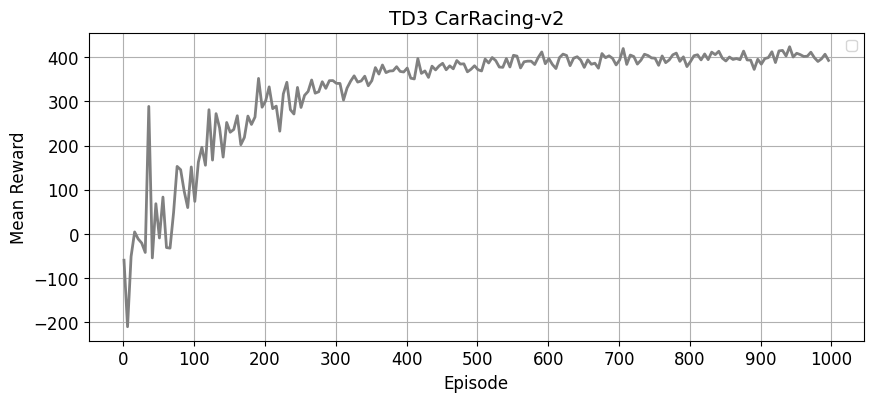

In [15]:
results_plotter.plot_results([log_dir], time_steps, results_plotter.X_EPISODES, "TD3 Training on Car Racing V2")
plt.show()

In [16]:
# Save as gif
render_example(env_id=env_id, continuous=True, render_frames=True, output_file="artifacts/animation/td3_car_racer.gif")

Saved evaluation GIF to "artifacts/td3_car_racer.gif"